In [15]:
# In the context of statistical arbitrage, if the z-score of the difference between the returns of the securities exceeds a certain threshold, this could indicate that the prices of the securities are deviating significantly from their statistical relationship. 
# This deviation may be temporary and could potentially be exploited by adjusting the positions in the securities in a way that profits from the expected return to normalcy.
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

# Load data for the two securities
df = pd.read_csv("stocks.csv", index_col=0)
print(df.columns.tolist())

# Calculate the daily returns for the securities
# dropna means dropping NA value
returns_1 = df['close_meta'].pct_change()
returns_2 = df['close_azeta'].pct_change()

returns__1 = pd.Series(returns_1)
returns1 = returns__1.dropna()
returns__2 = pd.Series(returns_2)
returns2 = returns__2.dropna()

print(returns1, returns2)

# Calculate the correlation between the returns, low correl is better 
correlation = returns1.corr(returns2)
print(correlation)

['close_meta', 'close_azeta']
Date
1/5/2018      0.013671
1/8/2018      0.007653
1/9/2018     -0.002178
1/10/2018    -0.000160
1/11/2018    -0.000373
                ...   
12/27/2022   -0.009827
12/28/2022   -0.010780
12/29/2022    0.040131
12/30/2022    0.000665
1/3/2023      0.036563
Name: close_meta, Length: 1257, dtype: float64 Date
1/5/2018      0.029157
1/8/2018     -0.001531
1/9/2018     -0.017255
1/10/2018    -0.015607
1/11/2018     0.017043
                ...   
12/27/2022   -0.007186
12/28/2022   -0.022058
12/29/2022    0.031366
12/30/2022   -0.005296
1/3/2023      0.012367
Name: close_azeta, Length: 1257, dtype: float64
0.42669201857843025


Text(0, 0.5, 'Portfolio_value')

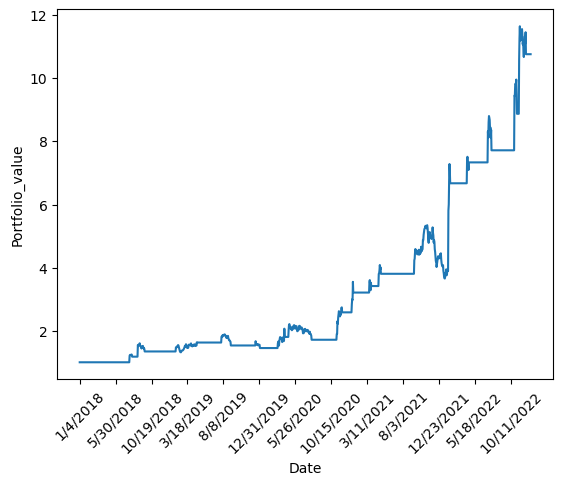

In [13]:
# Split the data into a training set and a test set
train_size = int(len(returns1) * 0.8)
returns1_train = returns1[:train_size]
returns2_train = returns2[:train_size]
returns1_test = returns1[train_size:]
returns2_test = returns2[train_size:]

# This code uses linear regression to fit the training data to the model
model = LinearRegression()
model.fit(returns1_train.values.reshape(-1,1), returns2_train.values.reshape(-1,1))

# Make predictions on the test data
predictions = model.predict(returns1_test.values.reshape(-1,1))

# Calculate the mean and standard deviation of the residuals
residuals = predictions - returns2_test.values.reshape(-1,1)
mean = np.mean(residuals)
std = np.std(residuals)

# Set the threshold for the z-score (depending on your risk attitude)
threshold = 3

# Set the stop-loss threshold (e.g. 5%)
stop_loss_threshold = 0.05

# Initialize the positions and the portfolio value
long = 0
short = 0
portfolio_value = 1

portfolio_values = []

# Start the loop
for i in range(len(returns1)):
  # Calculate the z-score using standard error
  z = (returns1[i] - returns2[i] - mean) / (std * np.sqrt(1 - correlation**2))
  
  # If the z-score exceeds the threshold, update the positions
  if z > threshold:
    long += 1
    short -= 1
  elif z < -threshold:
    long -= 1
    short += 1
    
  # Calculate the current return of the portfolio
  current_return = returns1[i] * long + returns2[i] * short
  
  # If the return falls below the stop-loss threshold, close the positions
  if current_return < -stop_loss_threshold:
    long = 0
    short = 0
  
  # Update the portfolio value
  portfolio_value *= (1 + current_return)
  portfolio_values.append(portfolio_value)

# Plot the final portfolio value
plt.plot(portfolio_values)
plt.xticks(np.arange(0, len(df), 100), df.index[::100], rotation=45)
plt.xlabel('Date')
plt.ylabel('Portfolio_value')

In [14]:
# Alternative calculation for threshold based on market fluctuations
std_1 = returns1.std()
std_2 = returns2.std()
mean_std = (std_1 + std_2) / 2
threshold = mean_std * 1